In [1]:
import sys
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import scanpy as sc
from matplotlib import pyplot as plt
import scmulti

In [4]:
%config InlineBackend.figure_format = 'retina'

# Load the dataset

In [5]:
scrna = sc.read_h5ad('../data/10xpbmc10k-2020/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 10000 × 3999
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [6]:
scatac = sc.read_h5ad('../data/10xpbmc10k-2020/peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 10000 × 40018
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

# Configure and train the model

In [7]:
model = scmulti.models.MultiVAE(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    pair_groups=[[0], [0]],
    z_dim=20,
    h_dim=128,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-4,
    integ_coef=1e-2,
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [8]:
model.train(
    n_iters=20000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=10000,
    validate_every=1000
)

/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


 |█-------------------| 5.0% iter=1001/20000, time=38.51(s), loss=0.2980, recon=0.2514, kl=38.4466, integ=4.6366, val_loss=0.2423, val_recon=0.2157, val_kl=49.8029, val_integ=2.6136
 |██------------------| 10.0% iter=2001/20000, time=38.20(s), loss=0.2348, recon=0.2193, kl=65.8785, integ=1.4377, val_loss=0.2251, val_recon=0.2122, val_kl=64.6101, val_integ=1.1554
 |███-----------------| 15.0% iter=3001/20000, time=38.10(s), loss=0.2243, recon=0.2151, kl=76.5637, integ=0.7207, val_loss=0.2197, val_recon=0.2105, val_kl=77.0467, val_integ=0.6865
 |████----------------| 20.0% iter=4001/20000, time=38.06(s), loss=0.2195, recon=0.2126, kl=85.0414, integ=0.3620, val_loss=0.2177, val_recon=0.2091, val_kl=83.6766, val_integ=0.5210
 |█████---------------| 25.0% iter=5001/20000, time=38.07(s), loss=0.2227, recon=0.2161, kl=86.9701, integ=0.2576, val_loss=0.2164, val_recon=0.2086, val_kl=83.1074, val_integ=0.3677
 |██████--------------| 30.0% iter=6001/20000, time=38.09(s), loss=0.2181, recon=0.211

## Plot training history

In [9]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,val_loss,val_recon,val_kl,val_integ
0,1000,0.298043,0.251429,38.446577,4.636590,0.242348,0.215713,49.802856,2.613648
1,2000,0.234829,0.219261,65.878485,1.437716,0.225073,0.212226,64.610144,1.155431
2,3000,0.224334,0.215134,76.563667,0.720705,0.219694,0.210518,77.046653,0.686515
3,4000,0.219501,0.212650,85.041351,0.362026,0.217688,0.209131,83.676564,0.521035
4,5000,0.222691,0.216117,86.970135,0.257639,0.216447,0.208615,83.107380,0.367700
5,6000,0.218092,0.211138,78.778534,0.238811,0.215234,0.208235,77.433150,0.235316
6,7000,0.220304,0.213234,78.810780,0.187274,0.214613,0.207765,72.910032,0.174393
7,8000,0.220337,0.213101,68.311371,0.191059,0.214106,0.207409,67.264039,0.131648
8,9000,0.215634,0.207978,66.637802,0.192753,0.214094,0.207251,62.268492,0.123907
9,10000,0.218492,0.210269,60.455055,0.229827,0.214337,0.207048,59.498871,0.133956


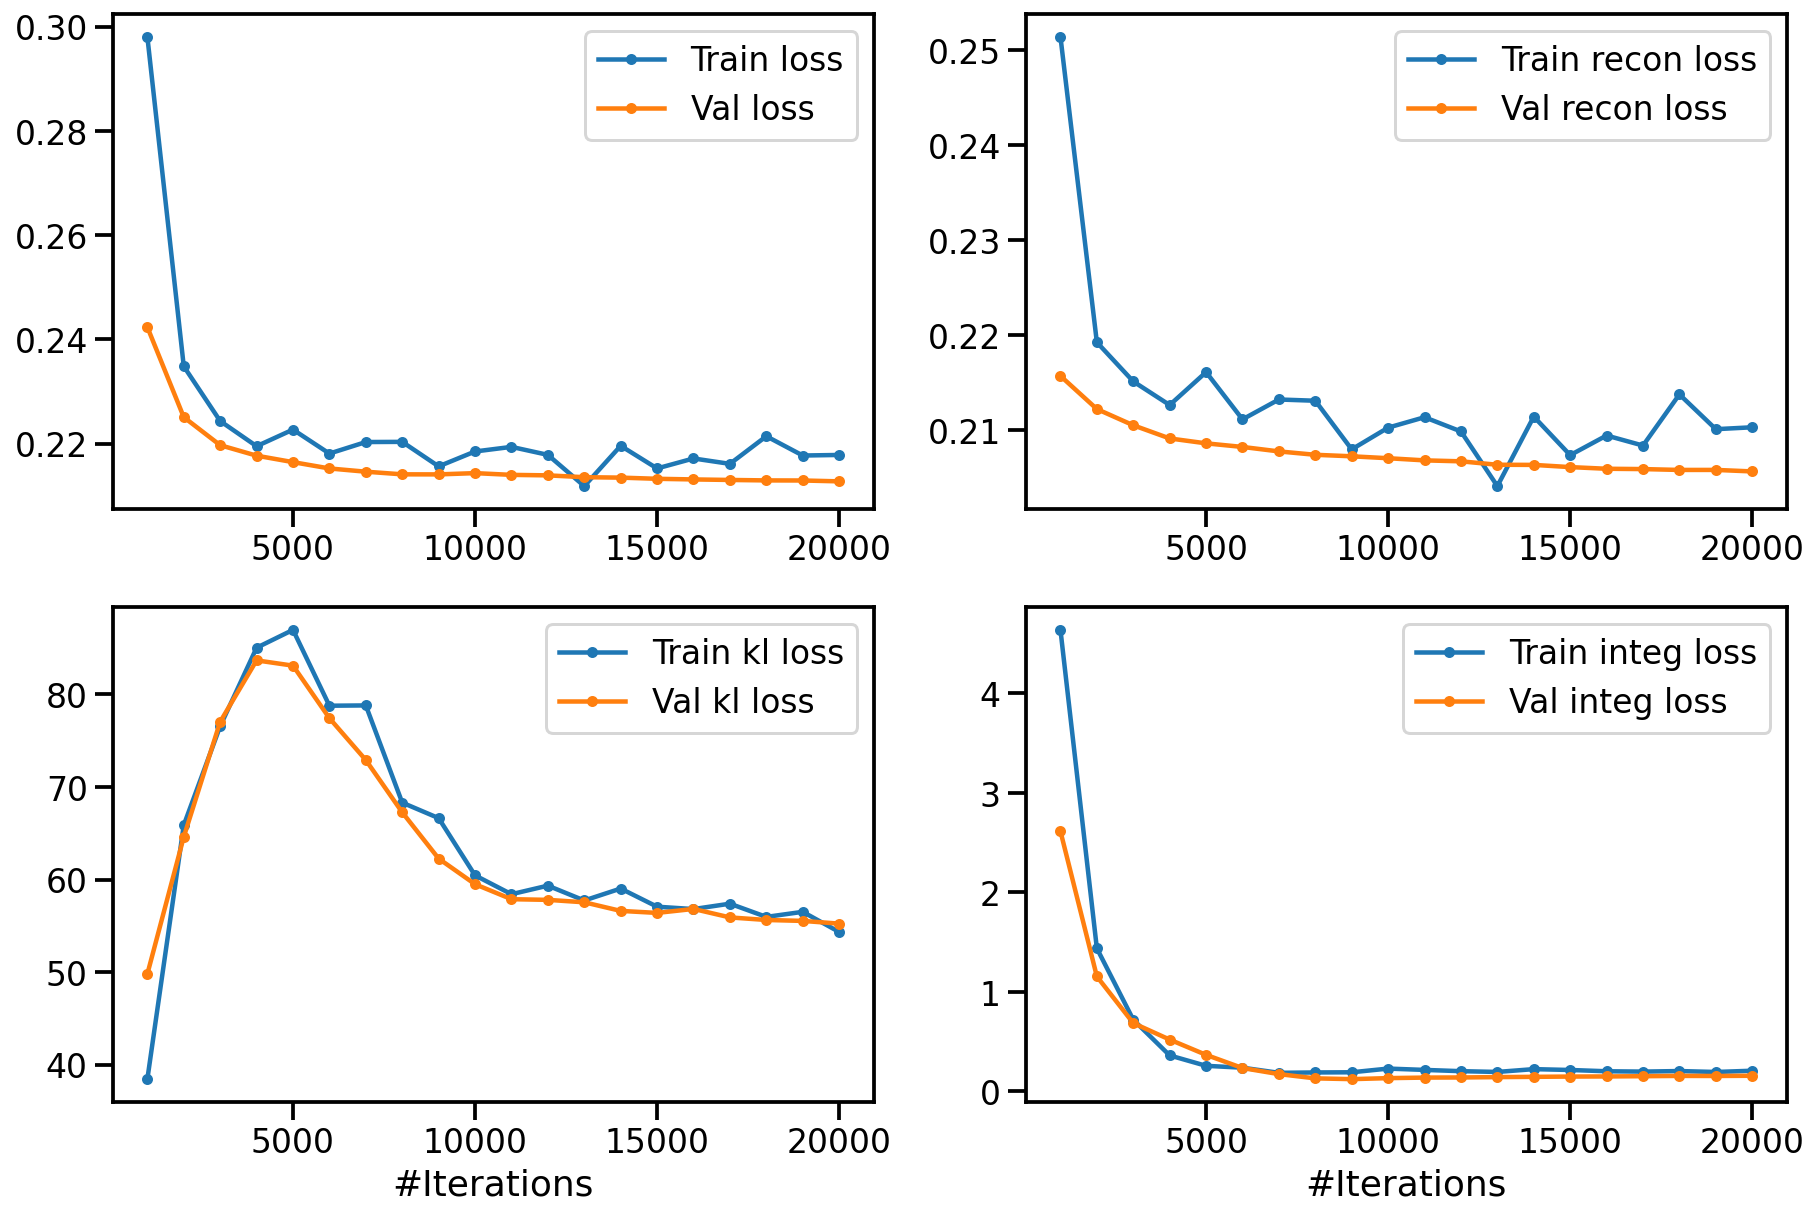

In [10]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

# Validation

### UMAP plot of the latent space

In [11]:
z = model.predict(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    batch_size=64,
)
z

/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 20000 × 20
    obs: 'modality', 'cell_type', 'batch'

In [12]:
sc.pp.neighbors(z)
sc.tl.umap(z)

/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'modality' as categorical
... storing 'cell_type' as categorical


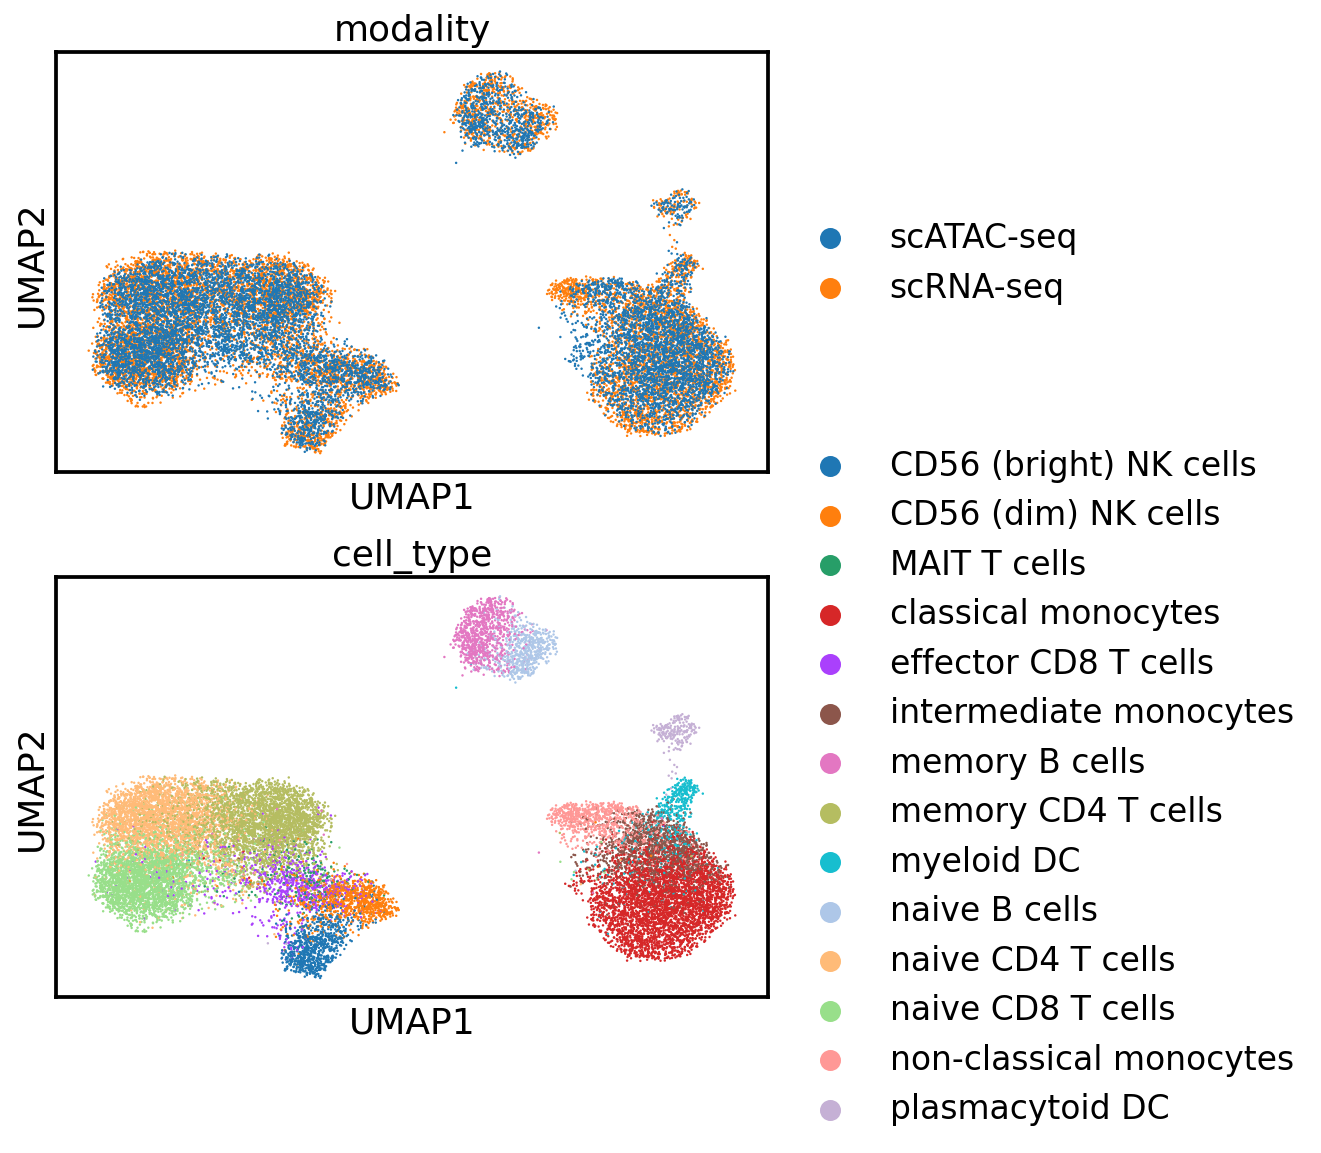

In [13]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)

### Metrics

In [14]:
scmulti.metrics.nmi(z, label_key='cell_type')

0.6824402338168827

In [15]:
scmulti.metrics.asw(z, label_key='modality')

0.0009271724848076701

In [16]:
scmulti.metrics.asw(z, label_key='cell_type')

0.07256915420293808

In [17]:
sc.pp.pca(z)
metrics = scmulti.metrics.scibmetrics.metrics(
    z, z,
    batch_key='modality',
    label_key='cell_type',
    hvg_score_=False,
    nmi_=True,
    ari_=True,
    silhouette_=True,
)
metrics

clustering...


/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/home/aomidi/.conda/envs/scanpy/lib/python3.7/sit

NMI...
ARI...
silhouette score...


/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi

,0
NMI_cluster/label,0.717586
ARI_cluster/label,0.626828
ASW_label,0.537097
ASW_label/batch,0.974401
PCR_batch,NaN
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,NaN
graph_conn,NaN
kBET,NaN
